# First attempt of clustering the publications from Science Mag.

#### Steps of BERTopic

![Alt text](./image/StepsOfBerTopic.png)

### Customizing is also possible
![Alt text](./image/Custmizing_SemanticScholar_Steps.png)

In [53]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# We have to define, which words we need to add
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.update(['said',"research",'scientist','studies'])
ENGLISH_STOP_WORDS = frozenset(stop_words)

import pickle

# Have check these to out
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, config
config.THREADING_LAYER = 'threadsafe'
from umap import UMAP
from collections import defaultdict
import re
import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired


In [54]:
# Function to load and clean the dataset
def load_clean_dataset(path,years=None):
    # Load the dataset from the specified path
    df = pd.read_csv(path)
    if years: df = df[df['year'].isin(years)]

    # Fill NaN values with empty strings
    df.fillna('', inplace=True)
    
    # List of columns to drop from the DataFrame
    columns_to_drop = [
        'paperId', 'paperId', 's2FieldsOfStudy', 'MAG', 'DOI', 'CorpusId',
        'ArXiv', 'DBLP', 'PubMed', 'PubMedCentral', 'id', 'issn',
        'alternate_issns', 'alternate_urls', 'type', 'publicationTypes', 'url'
    ]
    
    # Drop the specified columns from the DataFrame
    df_c = df.drop(columns=columns_to_drop, axis=1)

    # Function to clean and preprocess text data
    def clean_text(row):
        # Combine 'title' and 'abstract' into a single column
        combined_text = row['title'] + '. ' + row['abstract']

        # Check if 's2FieldsOfStudy' exists and is not empty
        if row['fieldsOfStudy']:
            combined_text += '. ' + ', '.join(row['fieldsOfStudy'])

        # Tokenize and remove stopwords
        cleaned_tokens = [word for word in combined_text.split() if word.lower() not in ENGLISH_STOP_WORDS]
        return ' '.join(cleaned_tokens)

    # Apply the clean_text function to each row to create a new 'title_abstract' column
    df_c['title_abstract_studyfield'] = df_c.apply(clean_text, axis=1)
    
    # Shuffle the DataFrame for randomness and reset the index
    df_c = df_c.sample(frac=1).reset_index(drop=True)
    
    print("Length of the dataset: ", len(df_c))
    print("Null in the dataset",df.isnull().sum())
    # Return the cleaned DataFrame
    return df_c

# Function to cluster data using BERTopic
def cluster_data(df,min_topic_size=50,fine_tune_label=False,get_topics=False,get_probs=False):  
    # Extract documents from the 'title_abstract_studyfield' column
    docs = df['title_abstract_studyfield'].tolist()
    
    # Measure the start time for model fitting
    start_time = time.time()
    
    # Create and fit a BERTopic model
    if fine_tune_label:
        representation_model = KeyBERTInspired()
        model = BERTopic(language="english", n_gram_range=(1, 2), min_topic_size=min_topic_size,representation_model=representation_model)
    else:
        model = BERTopic(language="english", n_gram_range=(1, 2), min_topic_size=min_topic_size)
    
    topics, probs = model.fit_transform(docs)
    
    # Calculate the elapsed time for model fitting
    elapsed_time_minutes = (time.time() - start_time) / 60
    
    # Print a message with the elapsed time
    print(f"Model fitting completed in {elapsed_time_minutes:.2f} minutes")
    
    # Return the model
    if get_topics & get_probs:
        return model,topics,probs
    elif get_topics:
        return model,topics
    elif get_probs:
        return model,probs
    return model

# Function to visualize the distribution of study fields
def viz_study_field_distribution(df, vis_length=None):
    # Set the default visualization length to the length of the DataFrame if not provided
    if vis_length is None:
        vis_length = len(df)

    # Calculate the counts of study fields
    source_counts = df['fieldsOfStudy'].value_counts()[:vis_length]

    # Create a figure and a single axis for the bar chart
    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot the study field counts as a bar chart
    source_counts.plot(kind='bar', color='lightblue', edgecolor='black', ax=ax)

    # Set the title and labels for the plot
    ax.set_title('Distribution of Study Fields')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(source_counts)))
    ax.set_xticklabels(source_counts.index, rotation=90, ha="right")

    # Ensure the plot layout is tight
    plt.tight_layout()

    # Display the plot
    plt.show()
    
# Expanding the df to include the topic labels
def add_topic_labels(df,topics,model):
    df['topic_code'] = topics
    topic_dict = model.get_topics()
    df['best_topic'] = df['topic_code'].apply(lambda x: topic_dict.get(x, [])[0][0])
    display(df.head())
    return df

# BERTopic on a single year

Length of the dataset:  104
Null in the dataset paperId                     0
title                       0
abstract                    0
year                        0
referenceCount              0
citationCount               0
influentialCitationCount    0
fieldsOfStudy               0
s2FieldsOfStudy             0
publicationTypes            0
publicationDate             0
MAG                         0
DOI                         0
CorpusId                    0
PubMed                      0
ArXiv                       0
DBLP                        0
PubMedCentral               0
id                          0
name                        0
type                        0
issn                        0
alternate_issns             0
url                         0
alternate_urls              0
dtype: int64


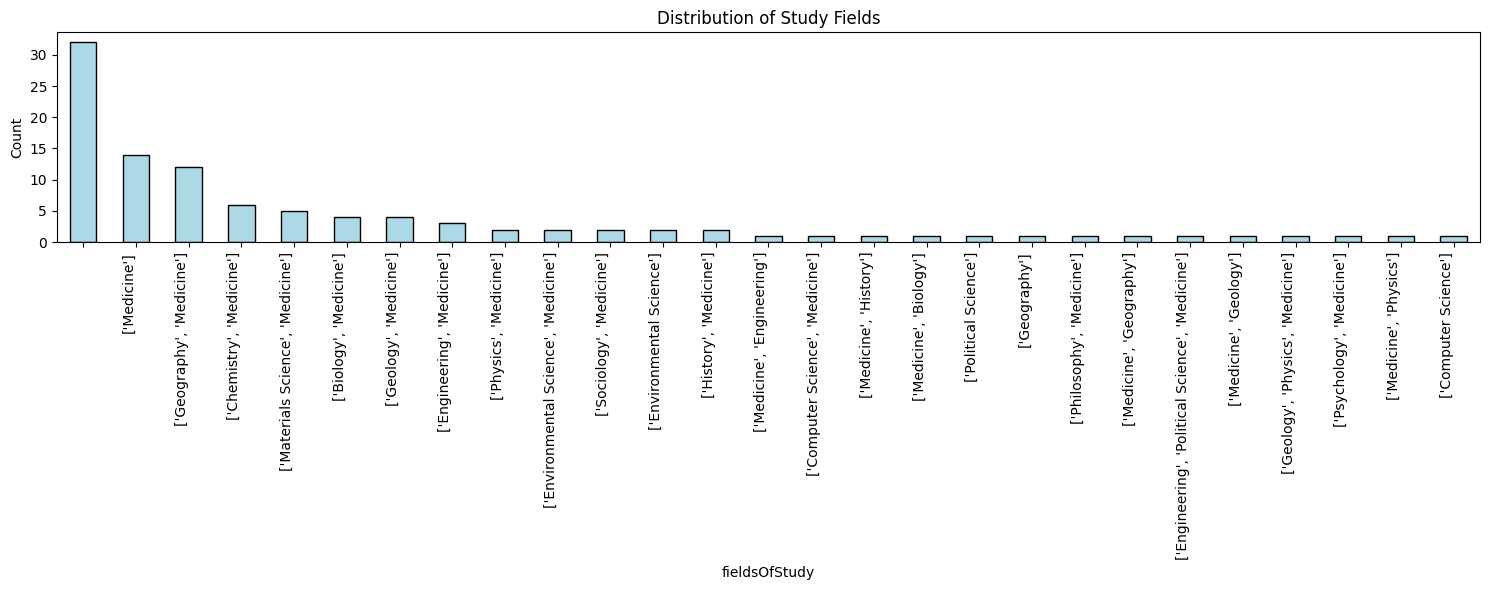

In [23]:
## Filter using the year:
years = [1900]
df = load_clean_dataset("./data/1880-2023_Science_48966.csv",years)
viz_study_field_distribution(df)

In [24]:
# Creating clusters for a single year
single_year_model = cluster_data(df,min_topic_size=5)
# Saving the BERTopic model
single_year_model.save("./models/bertopic_model_"+str(years[0]))
display(single_year_model.get_topic_info())
single_year_model.visualize_topics()

Model fitting completed in 0.07 minutes


,Topic,Count,Name,Representation,Representative_Docs
0,-1,37,-1_erotic_science_solution_work,"[erotic, science, solution, work, families, linguistic, amazon, images, sex, longest]","[Sounding Ocean Air . A. Lawrence Rotch, S.B., A.M. Romance Science Series. London, Society Prom..."
1,0,32,0_books_degeneration_water_conditions,"[books, degeneration, water, conditions, case, survey, larvae, time, study, work]",[Lampreys Captivity. HAVING living lampreys various ages observation biological laboratory Johns...
2,1,14,1_energy_new_effect_chemistry,"[energy, new, effect, chemistry, zeeman, york, electron, magnetic, levels, field]","[Calculations Analytical Chemistry . E. H. Miller, Ph.D., Instructor Analytical Chemistry Assayi..."
3,2,8,2_fowl_sterna_domesticated_deformed,"[fowl, sterna, domesticated, deformed, fox, exotic, ulke, coleoptera, blue, cruise]","[BLUE FOX TRAPPING PRIBILOF ISLANDS.. . [, ', M, a, t, e, r, i, a, l, s, , S, c, i, e, n, c, e, ..."
4,3,7,3_botanical_torrey_club_notes,"[botanical, torrey, club, notes, botany, 1900, twentieth, textbooks, structures, second]","[Torrey Botanical Club, October 9, 1900. . [, ', G, e, o, g, r, a, p, h, y, ', ], Torrey Botanic..."
5,4,6,4_society_biological_washington_medical,"[society, biological, washington, medical, activities, health, services, letter, cowie, will]","[Biological Society Washington., DISCLAIMER. Finally, benefit aforementioned correspondents, fee..."


# BERTopic on the whole Science data set

Length of the dataset:  48966
Null in the dataset paperId                     0
title                       0
abstract                    0
year                        0
referenceCount              0
citationCount               0
influentialCitationCount    0
fieldsOfStudy               0
s2FieldsOfStudy             0
publicationTypes            0
publicationDate             0
MAG                         0
DOI                         0
CorpusId                    0
PubMed                      0
ArXiv                       0
DBLP                        0
PubMedCentral               0
id                          0
name                        0
type                        0
issn                        0
alternate_issns             0
url                         0
alternate_urls              0
dtype: int64


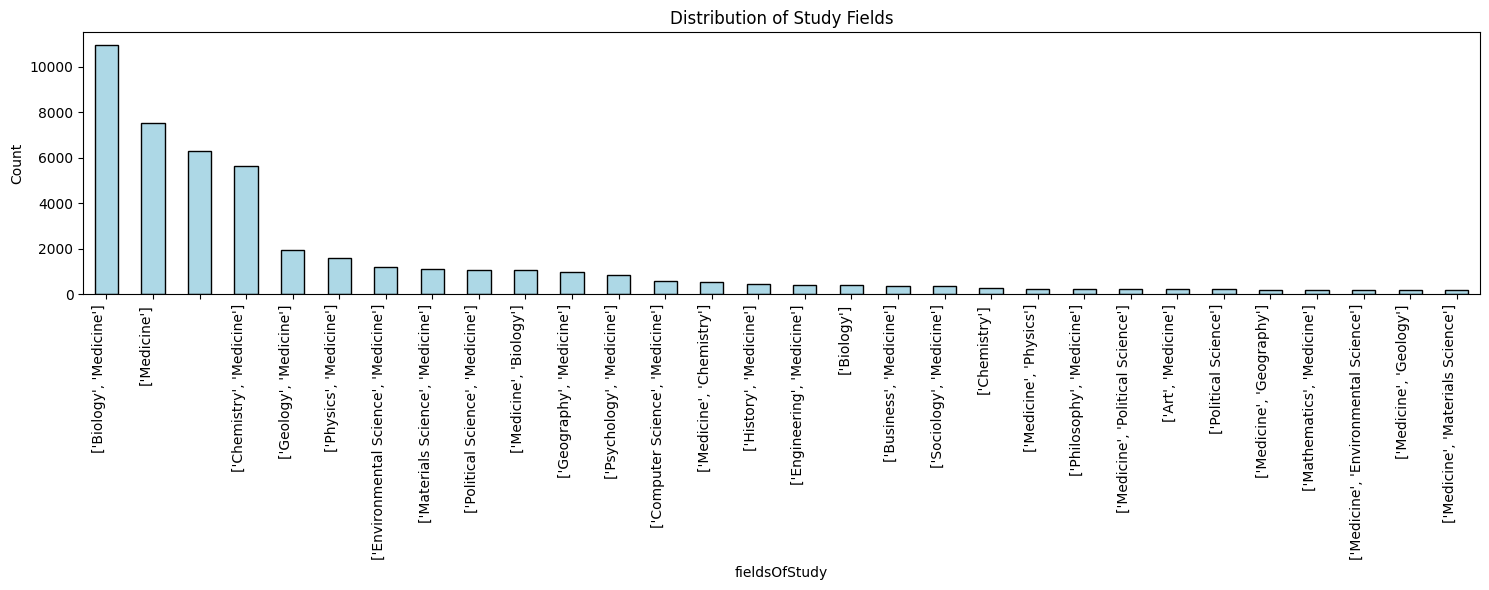

In [55]:
# Load the whole dataset
df = load_clean_dataset("./data/1880-2023_Science_48966.csv")
viz_study_field_distribution(df,30)

In [56]:
# Creating clusters for the whole data set
model,topics = cluster_data(df,min_topic_size=50,fine_tune_label=True,get_topics=True)
# Saving the BERTopic model
model.save("./models/bertopic_model_whole_data_set.brt")
display(model.get_topic_info())
model.visualize_topics()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/pclinux/spiced/data_science/capstone_project/convergence_oracle/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



,Topic,Count,Name,Representation,Representative_Docs
0,-1,25780,-1_gene_genes_genetic_rna,"[gene, genes, genetic, rna, cells, cell, biological, neurons, dna, cellular]",[Lentiviral Hematopoietic Stem Cell Gene Therapy Benefits Metachromatic Leukodystrophy. Introduc...
1,0,745,0_quantum hall_quantum_qubits_quantum information,"[quantum hall, quantum, qubits, quantum information, qubit, spins, entanglement, spin, photonic,...",[topological quantum optics interface. Connecting quantum emitters Exploiting topological proper...
2,1,741,1_chemistry_organic chemistry_chemistry vol_physical chemistry,"[chemistry, organic chemistry, chemistry vol, physical chemistry, compounds, chemical analysis, ...","[American Chemical Society, New York Section. . [, ', P, o, l, i, t, i, c, a, l, , S, c, i, e, n..."
3,2,715,2_honey bees_bees_honey bee_bee,"[honey bees, bees, honey bee, bee, honeybees, insecticides, pollination, honey, insects, pestici...",[Honey Bees Humans: Shared Innovation. discussion sequencing genome honey bee (“Honey bee genome...
4,3,557,3_nomenclature_books nomenclature_nomenclature rhcde_reference books,"[nomenclature, books nomenclature, nomenclature rhcde, reference books, agglutinogen, string, co...","[art triage.. halfway Ph.D. coursework struggling define nebulous topic, deadlines hurtling MATL..."
5,4,514,4_lamps_microscope_lantern slides_microscope slides,"[lamps, microscope, lantern slides, microscope slides, inductorium, glass, lamp, objects, lighti...",[BLOCKING-OUT UNDESIRABLE BACKGROUNDS PHOTOGRAPHS.. BLOCKING-OUT UNDESIRABLE BACKGROUNDS PHOTOGR...
6,5,504,5_antarctic ice_glacial maximum_glacial_greenland ice,"[antarctic ice, glacial maximum, glacial, greenland ice, climate change, glaciers, sea level, ic...",[Reconciled Estimate Ice-Sheet Mass Balance. Warming Melting Mass loss ice sheets Greenland Anta...
7,6,418,6_biodiversity conservation_biodiversity_global biodiversity_biodiversity loss,"[biodiversity conservation, biodiversity, global biodiversity, biodiversity loss, ecological, ec...",[biodiversity Anthropocene. Fire's growing impacts ecosystems played prominent role evolution bi...
8,7,397,7_meteorites_meteorite_carbonaceous chondrite_carbonaceous,"[meteorites, meteorite, carbonaceous chondrite, carbonaceous, asteroid, asteroids, lunar samples...",[surface composition asteroid 162173 Ryugu Hayabusa2 near-infrared spectroscopy. Hayabusa2 aster...
9,8,390,8_advancement science_scientific community_advancement_sciences,"[advancement science, scientific community, advancement, sciences, science including, researcher...",[Molecule year.. American Association Advancement Science Science serves readers forum presentat...


In [57]:
df = add_topic_labels(df,topics,model)

,title,abstract,year,referenceCount,citationCount,influentialCitationCount,fieldsOfStudy,publicationDate,name,title_abstract_studyfield,topic_code,best_topic
0,Synergistic activation of transcription by bacteriophage lambda cI protein and E. coli cAMP rece...,"Two heterologous prokaryotic activators, the bacteriophage lambda cI protein (lambda cI) and the...",1994,46,88,1,"['Biology', 'Medicine']",1994-09-23,Science,Synergistic activation transcription bacteriophage lambda cI protein E. coli cAMP receptor prote...,69,rna polymerases
1,The 1979 Nobel prize in physiology or medicine.,,1979,6,23,0,"['Computer Science', 'Medicine']",1979-11-30,Science,"1979 Nobel prize physiology medicine.. . [, ', C, o, m, p, u, t, e, r, , S, c, i, e, n, c, e, ',...",-1,gene
2,Seasonal exposure of carbon dioxide ice on the nucleus of comet 67P/Churyumov-Gerasimenko,"Rosetta observes sublimating surface ices Comets are “dirty snowballs” made of ice and dust, but...",2016,46,58,1,"['Medicine', 'Environmental Science']",2016-12-23,Science,Seasonal exposure carbon dioxide ice nucleus comet 67P/Churyumov-Gerasimenko. Rosetta observes s...,123,comet nucleus
3,A DROP METHOD OF PENICILLIN PRODUCTION.,,1944,2,1,0,"['Mathematics', 'Medicine']",1944-08-25,Science,"DROP METHOD PENICILLIN PRODUCTION.. . [, ', M, a, t, h, e, m, a, t, i, c, s, ', ,, , ', M, e, d,...",46,penicillin
4,Cellular Basis of Itch Sensation,A Separate System for Itch Processing It has been a long-standing question if itch is a subquali...,2009,26,542,31,['Medicine'],2009-09-18,Science,Cellular Basis Itch Sensation. Separate Itch Processing long-standing question itch subquality p...,-1,gene


In [60]:
model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,25780,-1_gene_genes_genetic_rna,"[gene, genes, genetic, rna, cells, cell, biological, neurons, dna, cellular]",[Lentiviral Hematopoietic Stem Cell Gene Therapy Benefits Metachromatic Leukodystrophy. Introduc...
1,0,745,0_quantum hall_quantum_qubits_quantum information,"[quantum hall, quantum, qubits, quantum information, qubit, spins, entanglement, spin, photonic,...",[topological quantum optics interface. Connecting quantum emitters Exploiting topological proper...
2,1,741,1_chemistry_organic chemistry_chemistry vol_physical chemistry,"[chemistry, organic chemistry, chemistry vol, physical chemistry, compounds, chemical analysis, ...","[American Chemical Society, New York Section. . [, ', P, o, l, i, t, i, c, a, l, , S, c, i, e, n..."
3,2,715,2_honey bees_bees_honey bee_bee,"[honey bees, bees, honey bee, bee, honeybees, insecticides, pollination, honey, insects, pestici...",[Honey Bees Humans: Shared Innovation. discussion sequencing genome honey bee (“Honey bee genome...
4,3,557,3_nomenclature_books nomenclature_nomenclature rhcde_reference books,"[nomenclature, books nomenclature, nomenclature rhcde, reference books, agglutinogen, string, co...","[art triage.. halfway Ph.D. coursework struggling define nebulous topic, deadlines hurtling MATL..."
5,4,514,4_lamps_microscope_lantern slides_microscope slides,"[lamps, microscope, lantern slides, microscope slides, inductorium, glass, lamp, objects, lighti...",[BLOCKING-OUT UNDESIRABLE BACKGROUNDS PHOTOGRAPHS.. BLOCKING-OUT UNDESIRABLE BACKGROUNDS PHOTOGR...
6,5,504,5_antarctic ice_glacial maximum_glacial_greenland ice,"[antarctic ice, glacial maximum, glacial, greenland ice, climate change, glaciers, sea level, ic...",[Reconciled Estimate Ice-Sheet Mass Balance. Warming Melting Mass loss ice sheets Greenland Anta...
7,6,418,6_biodiversity conservation_biodiversity_global biodiversity_biodiversity loss,"[biodiversity conservation, biodiversity, global biodiversity, biodiversity loss, ecological, ec...",[biodiversity Anthropocene. Fire's growing impacts ecosystems played prominent role evolution bi...
8,7,397,7_meteorites_meteorite_carbonaceous chondrite_carbonaceous,"[meteorites, meteorite, carbonaceous chondrite, carbonaceous, asteroid, asteroids, lunar samples...",[surface composition asteroid 162173 Ryugu Hayabusa2 near-infrared spectroscopy. Hayabusa2 aster...
9,8,390,8_advancement science_scientific community_advancement_sciences,"[advancement science, scientific community, advancement, sciences, science including, researcher...",[Molecule year.. American Association Advancement Science Science serves readers forum presentat...


In [58]:
topic_dict = model.get_topics()
display(topic_dict)

{-1: [('gene', 0.35129634),
  ('genes', 0.33849025),
  ('genetic', 0.2889175),
  ('rna', 0.26319957),
  ('cells', 0.24058232),
  ('cell', 0.22981471),
  ('biological', 0.2178951),
  ('neurons', 0.18863629),
  ('dna', 0.17353527),
  ('cellular', 0.16785812)],
 0: [('quantum hall', 0.5525244),
  ('quantum', 0.4909948),
  ('qubits', 0.41799733),
  ('quantum information', 0.40528637),
  ('qubit', 0.39354807),
  ('spins', 0.38255805),
  ('entanglement', 0.37509727),
  ('spin', 0.36594564),
  ('photonic', 0.29211426),
  ('photons', 0.27958828)],
 1: [('chemistry', 0.6533936),
  ('organic chemistry', 0.63895214),
  ('chemistry vol', 0.6332191),
  ('physical chemistry', 0.6313164),
  ('compounds', 0.62871677),
  ('chemical analysis', 0.6237942),
  ('chemist', 0.5969386),
  ('inorganic chemistry', 0.59396243),
  ('american chemical', 0.5918654),
  ('chemists', 0.585139)],
 2: [('honey bees', 0.57790697),
  ('bees', 0.5699355),
  ('honey bee', 0.5250279),
  ('bee', 0.50393033),
  ('honeybees', 0